### Leerdoelen
- Je leert een Business Understanding te formuleren bij een opdrachtgever en een gegeven dataset. 
- Je leert wat een decision tree is
- Je leert werken met decision trees in Python
- Je leert je conslusies uit het Data Understanding te verbinden aan de uitkomst van je decision tree
- Je leert een keuze tussen decision trees van verschillende complexiteit
- Je leert de voorspellingen van je decision tree beoordelen. 

### Achtergrondinformatie:
- Google naar:
    - `python sklearn decision tree`
    - (optioneel) `python sklearn visualise decision tree`

### Opdracht 
- Vul het onderstaande notebook aan op de gevraagde plekken. 

# Business Understanding
De gemeente Boston in de VS worstelt met armoede problematiek. Een probleem voor de gemeente is dat ze geen inzicht hebben in welke factoren van invloed zijn op of een persoon wel of niet arm is. Om dit inzicht te verkrijgen heeft de gemeente jullie benaderd om hier inzicht in te verschaffen. 

# Les 1
# Data Understanding
We baseren onze analyse op de [adult dataset](https://archive.ics.uci.edu/ml/datasets/adult). Deze dataset geeft van een groot aantal mensen eigenschappen en een uitspraak over of ze meer of minder dan 50.000 (50K) dollar per jaar verdienen. Deze dataset bestaat uit de volgende variabelen:

In [4]:
import pandas as pd
import seaborn as sn
import numpy as np

# Lieve collega's, let op dat er vaak spaties in veldnamen en kolomnamen zullen staan!
adult = pd.read_csv('Data/adult.csv')
adult.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,above_or_below_50k
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


waar:

- `age`, leeftijd
- `workclass`, het soort werker wat de persoon doet
- etc
- `sex` het geslacht van de persoon
- `education` hoogst genoten opleiding als string
- `education-num` hoogst genoten opleiding als een ordinale variabele
- etc

We hebben het vermoeden dat een aantal variabelen een invloed gaan hebben op het inkomen:

- `age` hoe ouder iemand is hoe meer hij of zij verdient over het algemeen
- `sex` het vermoeden is dan mannen over het algemeen meer verdienen dan vrouwen
- `education-num` hoe meer opleiding hoe hoger het inkomen is

Om dit vermoeden te toetsen gaan we voor de mogelijke combinaties van deze drie variabelen kijken wat het percentage mensen is die meer dan 50K dollar verdient:

In [5]:
# We vervangen de labels in adult, meer leesbaar
adult['above_or_below_50k'] = adult['above_or_below_50k'].replace({' <=50K': 'below', ' >50K': 'above'})

In [6]:
## Bekijk de code hieronder en leg uit wat je ziet

def get_pct_above_50k(vec):
    # Returns percentage of observed subjects that make above 50K
    cnt = vec.value_counts()
    try:
        return 100 - ((cnt['below'] / sum(cnt)) * 100)
    except KeyError:
        return 100
    
res = adult[[' education-num', 'sex', 'age', 'above_or_below_50k']] \
          .groupby([' education-num', 'sex', 'age'])\
          .agg(get_pct_above_50k).reset_index()
res.tail()

,education-num,sex,age,above_or_below_50k
1698,16,Male,74,100.000000
1699,16,Male,75,33.333333
1700,16,Male,77,100.000000
1701,16,Male,79,100.000000
1702,16,Male,80,0.000000


Bijvoorbeeld laagopgeleide vrouwen van 23 jaar oud hebben 0 procent kans om meer dan 50K dollar te verdienen. Om alle categorieen te verkennen zetten we deze in het volgende plot:

C:\Users\yanni\Documents\Code\Python\Data Science\.venv\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


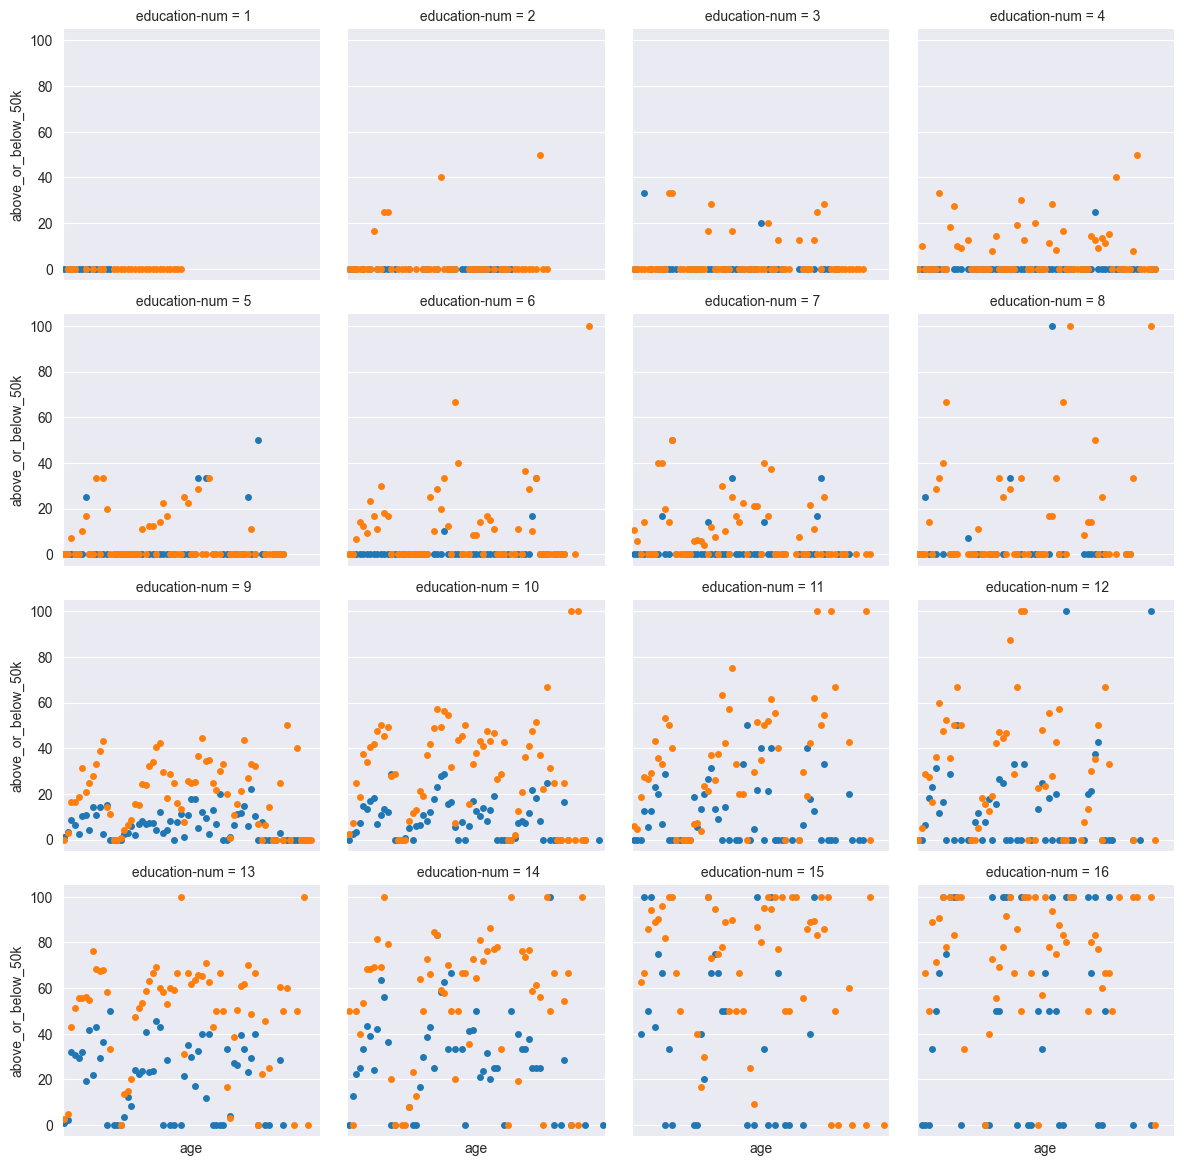

In [7]:
g = sn.FacetGrid(res, col=' education-num', hue='sex', col_wrap=4)
h = g.map(sn.stripplot, 'age', 'above_or_below_50k', jitter=False) # Voor seaborn > 0.12 gebruik native_scale = True
#h = g.map(sn.regplot, 'age', 'above_or_below_50k', lowess=True)
g.set(xticks=[])

Dit laat op de x-as de leeftijd zijn, op de y-as het percentage mensen meer dan 50K dollar, de oranje punten zijn man, de blauwe vrouw, en de verschillende plotjes geven de verschillende opleidingsniveaus. In dit plot zien we de volgende trends:

- Laag opgeleide mensen hebben een veel kleinere kans om meer dan 50K te verdienen.
- De kans voor 50K of meer wordt groter bij een toenemende leeftijd. Dit neemt na een bepaalde leeftijd (~50) weer af. 
- Vrouwen verdienen over het algemeen minder dan mannen, dit effect wordt sterker bij hogere leeftijden. 

Dit plot bevestiged dat deze drie variabelen een rol spelen bij de kans op een hoog inkomen. 

# Data Preparation
In aanvulling op het aanpassen van de labels naar `above` en `below` zijn er nog een aantal andere bewerkingen op de data noodzakelijk. 

Eerst gaan we alleen de variabelen selecteren waarin we interesse hebben, en splitsen we deze over twee dataobjecten:

In [8]:
## Welke data is categorisch? Maak hiervoor een dummy variabele
## Maak vervolgens twee datasets, één is voor de onafhankelijke kolommen, de andere is voor de afhankelijke kolom

dep_var = adult['above_or_below_50k']
indep_var = adult[[' education-num', 'sex', 'age']]

De eerste zijn de afhankelijke variebelen (predictors) waarmee het model gaat voorspellen, de tweede is een vector met uitkomsten. 

### Werken met categorische data
Tot nu toe hebben we alleen gewerkt met numerieke variabelen, maar in de praktijk werken we ook veel met categorische variabelen. Bij de les over lineare regressie hebben we het hier al kort over gehad (`"mpg ~ wt + C(cyl)"`, maar hier gaan we iets meer de diepte in. 

In de praktijk komen we categorische data op twee manieren tegen:

- Als tekst. Een goed voorbeeld hiervan is de `sex` kolom in de data waarmee we nu werken. Hier kan de decision tree niet goed mee omgaan. 
- Als getal. Een goed voorbeeld hiervan is de `cyl` kolom uit de regressie les. De getallen stellen we het aantal cylinders voor, maar je kunt geen 3.5 cillinders hebben. 

In beide gevallen moeten we de variabelen omzetten naar een zogenaamde dummy variabele. 

In [9]:
# [5 min] Genereer hier de dummy variabele voor de `sex` kolom via pd.get_dummies. Doe dit voor 
#         zowel `drop_first=True` als `drop_first=False`
pd.get_dummies(indep_var['sex']).head()

,Female,Male
0,False,True
1,False,True
2,False,True
3,False,True
4,True,False


In [10]:
pd.get_dummies(indep_var['sex'], drop_first=True).head()

,Male
0,True
1,True
2,True
3,True
4,False


Met `drop_first=False` krijgen we twee kolommen:

- `Female` welke 1 is als de persoon een vrouw is en 0 als dit niet het geval is
- `Male` welke 1 is als de persoon een man is en 0 als dit niet het geval is

Als we `drop_first=True` gebruiken houden we nog maar 1 kolom over, `Male`. Deze is 1 als de persoon een man is, en 0 als de persoon een vrouw is. We kunnen dus alle informatie over man vs vrouw vastleggen in maar 1 kolom. Dit is waarom we eigenlijk altijd `drop_first=True` gebruiken als we handmatig dummies maken. Dit is trouwens ook het gedrag van statsmodels als we `C(cyl)` gebruiken. 

Belangrijk hier is dat we van de `education-num` variabele geen dummies maken, terwijl ook dit een categorische variabele is. De reden waarvoor is een buiten de scope van dit college, maar details zijn [hier te vinden](https://web.archive.org/web/20200924113639/https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/). 

In [11]:
# [10 min] Vervang de `sex` kolom door de enkele dummy variabele
indep_var = pd.get_dummies(indep_var, drop_first=True, columns=['sex'])
indep_var

,education-num,age,sex_ Male
0,13,39,True
1,13,50,True
2,9,38,True
3,7,53,True
4,13,28,False
...,...,...,...
32556,12,27,False
32557,9,40,True
32558,9,58,False
32559,9,22,True


# Modeling: het leeftijdsmodel

In [12]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
                                                                                     
indep_var_train, indep_var_test, dep_var_train, dep_var_test = train_test_split(indep_var[['age']], dep_var, test_size=0.3)
                                                                                  # ['age'], anders loopt de code vast
clf = DecisionTreeClassifier().fit(indep_var_train, dep_var_train)
print(f1_score(dep_var_test, clf.predict(indep_var_test), pos_label='above'))
cm = pd.DataFrame(confusion_matrix(dep_var_test, clf.predict(indep_var_test)), 
             columns=['above', 'below'], 
             index=['above', 'below'])
cm

0.0


,above,below
above,0,2381
below,0,7388


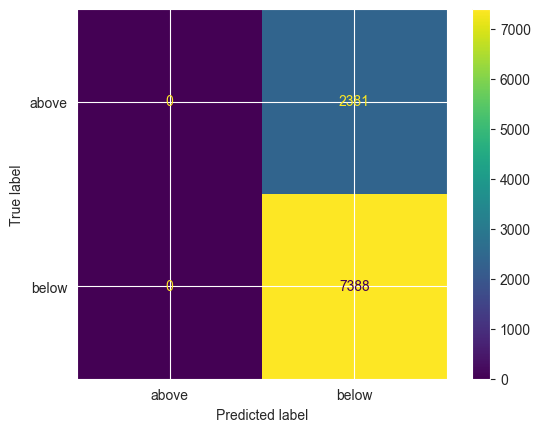

In [13]:
# visualise the confusion matrix using sklearn
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay(confusion_matrix(dep_var_test, clf.predict(indep_var_test)), display_labels=clf.classes_).plot()

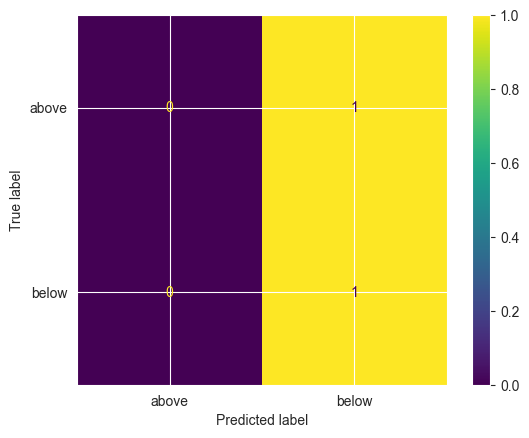

In [14]:
# Optioneel: deel elke rij door de som van de rij. Dan krijg je de fractie voorspeld. 
ConfusionMatrixDisplay(confusion_matrix(dep_var_test, clf.predict(indep_var_test), normalize='true'), display_labels=clf.classes_).plot()

Conclusie: het age model is verschrikkelijk slecht. Het geeft aan dat iedereen lager dan 50k verdient. 

# Les 2
# Modeling: alle modellen
Nu gaan we aantal combo's uitrekenen

In [15]:
def fit_decision_tree(varlist):
    indep_var_train, indep_var_test, dep_var_train, dep_var_test = train_test_split(indep_var[varlist], dep_var, test_size=0.3)
                                                                                      #^^^^^^ drop!! om education eruit te gooien
    clf = DecisionTreeClassifier().fit(indep_var_train, dep_var_train)
    f1 = f1_score(dep_var_test, clf.predict(indep_var_test), pos_label='above')
    cm = pd.DataFrame(confusion_matrix(dep_var_test, clf.predict(indep_var_test)), 
                 columns=['above', 'below'], 
                 index=['above', 'below'])
    return [f1, (cm.transpose() / cm.sum(axis=1)).transpose(), clf]

age_f1, age_cm, age_model = fit_decision_tree(['age'])
edu_f1, edu_cm, edu_model = fit_decision_tree([' education-num'])
sex_f1, sex_cm, sex_model = fit_decision_tree(['sex_ Male'])
age_sex_f1, age_sex_cm, age_sex_model = fit_decision_tree(['age', 'sex_ Male'])
sex_edu_f1, sex_edu_cm, sex_edu_model = fit_decision_tree(['sex_ Male', ' education-num'])
age_edu_f1, age_edu_cm, age_edu_model = fit_decision_tree(['age', ' education-num'])
all_f1, all_cm, all_model = fit_decision_tree(['age', 'sex_ Male', ' education-num'])

In [16]:
pd.Series([age_f1, sex_f1, edu_f1, age_sex_f1, sex_edu_f1, age_edu_f1, all_f1], 
          index=['age', 'sex', 'edu', 'age_sex', 'sex_edu', 'age_edu', 'all'])

age        0.000853
sex        0.000000
edu        0.306181
age_sex    0.170576
sex_edu    0.481838
age_edu    0.462776
all        0.486236
dtype: float64

Als we kijken naar de modellen met 1 var, dan is alleen education iets wat echt wat toevoegd. De tweevoudige combo's liken het niet echt veel beter te doen dan de edu alleen. Het model met alles is het beste. Blijkbaar voegen sex en age in combinatie met edu wel echt wat toe. Mooi!

In [17]:
edu_cm

,above,below
above,0.205532,0.794468
below,0.043402,0.956598


In [18]:
import seaborn as sns

all_cm

,above,below
above,0.400933,0.599067
below,0.078926,0.921074


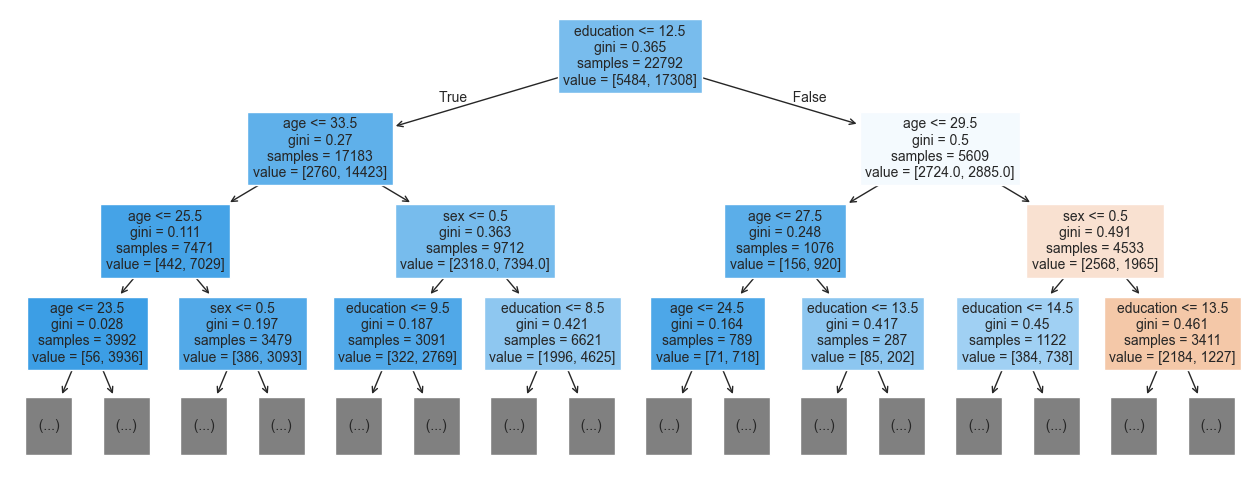

In [21]:
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16,6))  # set plot size (denoted in inches)
ignore_output = tree.plot_tree(all_model, max_depth = 3, fontsize=10,
                              feature_names = ['age', 'sex', 'education'],
                              filled = True)

Door in te zoomen op de confusionmatrix kunnen we zien dat we vooral veel winnen bij mensen die `above` zijn, maar foutief als `below` worden geclassificeerd. Dit is wel logisch omdat leeftijd en sekse nog veel uitmaken als het aankomt op inkomen, maar wel met edu als sterktse onderliggende driver. Zie ook de gridplot eerder in het verhaal. 

# Evaluation
Onze vraag was welke variabelen van invloed zijn op de inkomens verdeling. Uit onze analyse blijkt dat:

- Mannen meer verdienen dan vrouwen in onze data
- Inkomen sterk gekoppeld is aan het opleidingsniveau
- Leeftijd ook een sterk verband heeft met de kans op een hoog inkomen. De piek hier ligt tussen de 40 en de 50 jaar oud. 

Qua invloed is education het sterkste, deze kan op zichzelf al een redelijke voorspelling geven. Dit wordt ook verder bevestigd doordat education helemaal bovenaan de tree staat. Maar als we dan de effecten van leeftijd en sekse meenemen wordt de performance veel beter. Sekse en leeftijd op zichzelf geven geen goede modellen. Dit wordt ook verder ondersteunt door de boom, onder de education komen age en sex weer prominent terug. 

Het uiteindelijke `all` model kan wel goed voorspellen wie `lager` dan 50k verdient, maar heeft meer moeite met accuraat de hogere verdieners eruit te halen. Daar classificeren we nog 60% fout. 

Vooral als je tijdens je eindproject met decision trees aan de slag gaat is dit een zeer waardevolle toevoeging aan je arsenaal. 